# Imports

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import os
import scanpy as sc
from anndata import read_h5ad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tqdm.auto import tqdm
import seaborn as sns
import pyranges as pr
from scipy import sparse, stats

In [2]:
# import atac-metacell-utilities functions
sys.path = ["../src"] + sys.path
from pl import enhancer_plot, setup_cmap_and_legend, discretize_colors, get_peak_deltas
from util import load_module
from density_analysis import density_analysis as da

# Load data

Uncomment the cell below to download the dataset used to generate this example.

In [3]:
#! aws s3 sync s3://fh-pi-setty-m-eco-public/mellon-tutorial/  ../data/

Before running this notebook, make sure the `diff_acc` and `gp_corrs` rules of the `atac-metacell-utilities` pipeline have been run successfully. The output of these rules is required to run this notebook.

In [4]:
data_dir = "../data/"
rna_annData_file = data_dir + "preprocessed_t-cell-depleted-bm-rna.h5ad" 
atac_annData_file =  data_dir + "preprocessed_t-cell-depleted-bm-atac.h5ad" 

In [5]:
rna_ad = read_h5ad(rna_annData_file)
atac_ad = read_h5ad(atac_annData_file)

In [6]:
rna_ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

In [7]:
atac_ad

AnnData object with n_obs × n_vars = 8627 × 216477
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'Bcells_primed', 'Bcells_lineage_specific'
    uns: 'FIMOColumns', 'GeneScoresColumns', 'InSilicoChipColumns', 'celltype_colors', 'celltype_combined_colors', 'leiden', 'leiden_colors', 'neighbors', 'phenograph_colors', 'tab20', 'umap'
    obsm: 'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
    varm: 'FIMO', 'InSilicoChip', 'InSilicoChip_Corrs', 'OpenPeaks'
    layers: 'tf_idf'
    obsp: 'ImputeWeights', 'connectiv

# Set plotting parameters and lineage of interest

In [8]:
n_genes = 100
min_peaks = 4
target_lineage = 'NaiveB'
target_peak_lineage = 'Bcells'
target_fate = 'proB'
base_fate = 'HSC'
dorc_pval = 1.0

## Load output from atac-metacells-utility pipeline

In [9]:
#differential accessibility fille for target cell type vs. stem cell type
peak_file = f'../results/diff_acc/{target_fate}_{base_fate}_diff_acc.tsv'
#SEACells gene-peak correlations
gene_peak_scores_file = '../results/gp_corr/gp_corr.pickle'

In [10]:
#Subset peaks to only peaks annotated as primed or lineage-specific in the target lineage"
peaks = pd.read_csv(peak_file, sep = "\t", index_col= 0)
peaks = peaks[atac_ad.var[f'{target_peak_lineage}_primed'] | atac_ad.var[f'{target_peak_lineage}_lineage_specific']]
peaks

/loc/scratch/24691136/ipykernel_3161/2688512778.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = peaks[atac_ad.var[f'{target_peak_lineage}_primed'] | atac_ad.var[f'{target_peak_lineage}_lineage_specific']]


logFC      padj_fdr  groupA_N  groupB_N  \
feature                                                              
chr2:231672408-231672908  -8.459  3.200000e-23       6.0       3.0   
chr19:42129437-42129937   -8.392  8.960000e-22       6.0       3.0   
chr5:139747147-139747647  -5.545  8.960000e-22       6.0       3.0   
chr10:124601330-124601830 -8.339  1.530000e-20       6.0       3.0   
chr12:123131799-123132299 -8.347  2.140000e-20       6.0       3.0   
...                          ...           ...       ...       ...   
chrX:68432583-68433083     0.000  1.000000e+00       NaN       NaN   
chrX:71112012-71112512     0.000  1.000000e+00       NaN       NaN   
chrX:7146660-7147160       0.000  1.000000e+00       NaN       NaN   
chrX:78331666-78332166     0.000  1.000000e+00       NaN       NaN   
chrX:9472654-9473154       0.000  1.000000e+00       NaN       NaN   

                           mean_groupA  mean_groupB  
feature                                              
chr2:231672408-231672908          4.56         0.00  
chr19:42129437-42129937           4.38         0.00  
chr5:139747147-139747647          4.68         0.78  
chr10:124601330-124601830         4.58         0.00  
chr12:123131799-123132299         4.52         0.00  
...                                ...          ...  
chrX:68432583-68433083            0.21         0.00  
chrX:71112012-71112512            0.27         0.00  
chrX:7146660-7147160              0.27         0.00  
chrX:78331666-78332166            0.27         0.00  
chrX:9472654-9473154              0.27         0.00  

[18589 rows x 6 columns]

## Create dictionary of lineage masks from branch masks stored in rna_ad.obsm

In [11]:
branch_mask_df = pd.DataFrame(rna_ad.obsm['branch_masks'], index = rna_ad.obs_names, columns = rna_ad.uns['custom_branch_mask_columns'])
fate_dict=dict()
for col in branch_mask_df.columns:
    fate_dict[col] = branch_mask_df[col]

/loc/scratch/24691136/ipykernel_3161/134065165.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lineages = pd.Series(index = rna_ad.obs_names)


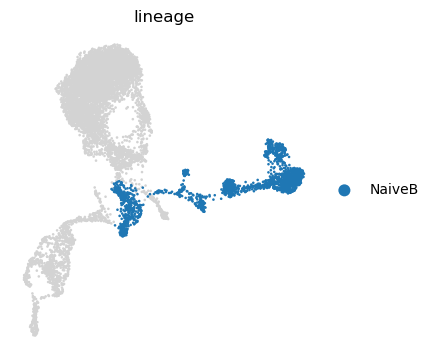

In [12]:
#Add lineage information to rna_ad.obs
lineages = pd.Series(index = rna_ad.obs_names)
for lineage in fate_dict.keys():
    lineages[fate_dict[lineage]] = lineage
rna_ad.obs['lineage'] = lineages
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.scatter(rna_ad, basis='umap', color='lineage', frameon = False)

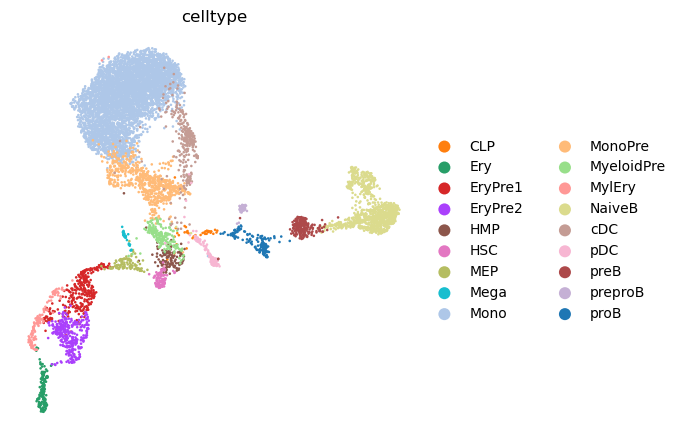

In [13]:
#Verify that branch annotations match expected celltypes
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon = False)

## Load gene-peak correlations

In [14]:
with open (gene_peak_scores_file, "rb") as handle:
    gene_peak_scores =pickle.load(handle)

## Prepare differential gene expression using scanpy.tl.rank_genes_groups

In [15]:
sc.tl.rank_genes_groups(rna_ad, groupby = 'celltype', rankby_abs = True, groups = [target_lineage], reference = base_fate, use_raw = False)
ct_genes = rna_ad.uns['rank_genes_groups']
diff_gene_exp = dict()
for celltype in [target_lineage]:
    diff_gene_exp[celltype] = da.process_gene_ranks(ct_genes, celltype)
    diff_gene_exp[celltype].rename({"logfoldchanges": "logFC"}, inplace = True, axis = 1)

In [16]:
gene_info_df = diff_gene_exp[target_lineage]
gene_info_df

pvals      pvals_adj      logFC      log10p
FCRL1        0.000000e+00   0.000000e+00  37.329556  200.000000
MS4A1       5.637793e-193  2.427916e-189  10.717134  188.614766
NKAIN2       4.626907e-78   2.213975e-75 -14.540007   74.654827
PAX5        9.955049e-111  1.008739e-107  10.172239  106.996221
INPP4B       1.566179e-74   6.580245e-72 -13.621899   71.181758
...                   ...            ...        ...         ...
AL162464.2   1.000000e+00   1.000000e+00   0.000000   -0.000000
AL162464.1   1.000000e+00   1.000000e+00   0.000000   -0.000000
AC008534.1   1.000000e+00   1.000000e+00   0.000000   -0.000000
AC007376.2   1.000000e+00   1.000000e+00   0.000000   -0.000000
TNFRSF9      1.000000e+00   1.000000e+00   0.000000   -0.000000

[17226 rows x 4 columns]

# Structure of enhancer plots

The plots produced in this notebook display both differential gene expression and the differential accessibility of the peaks significantly correlated to each gene's expression. Genes are plotted in order of most negative to most positive logFC RNA expression along the X axis. The stacked dots above each gene represent the number of peaks correlated to the expression of the gene and are ordered by most negative to most positive logFC accessibility, with the Y axis position of the first dot matching the logFC RNA expression for that gene. Grouping can be used to add large spaces to separate the stack of peaks into discrete categories - in the examples provided here, the peaks are grouped into downregulated, unchanged, and upregulated peaks. 

The example shown uses continuous colors to represent the logFC accessibility, but a discrete color scale can also be used to color the cells by groups. This can be performed by preparing color annotations using `discretize_colors`.

![](images/plot_example.png)

# Enhancer plot examples

## Prepare peak deltas (logFC accessibility values) for correlated peaks

In [17]:
cell_idx = rna_ad.obs_names[rna_ad.obs["lineage"] == target_lineage]
all_deltas = peaks.loc[peaks.index.isin(atac_ad.var_names),'logFC'].copy()
dorc_peak_deltas = get_peak_deltas(
    rna_ad, target_lineage, all_deltas, gene_peak_scores, invert_deltas = True
)

NaiveB:   0%|          | 0/17226 [00:00<?, ?it/s]

## Define continuous colors from the dorc_peak_deltas for the current fate

In [18]:
cont_colors = dorc_peak_deltas

## Prepare discretized colors for upregulated, downregulated, and unchanged peaks

In [19]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300

# Define a dictionary for colormap and legend elements.
# This will be used for discretely coloring and grouping the data.
cmapdict = {
    "up-regulated": "#D13927",
    "unchanged": (0.7, 0.7, 0.7, 1.0),
    "down-regulated": "#4A7CB5",
}
# Call setup_cmap_and_legend function with the cmapdict to generate colormap and legend elements.
cmap, legend_elements = setup_cmap_and_legend(cmapdict)

# Define a threshold for discretizing colors.
discretize = (-0.02, 0.02)

# Call discretize_colors function to discretize the continuous colors.
# disc_colors is a dictionary of {gene: peak_group_assignments} where each gene is assigned to a peak group.
# The number of different groups is the same as the number of colors defined in cmapdict.
disc_colors = discretize_colors(dorc_peak_deltas, discretize)

# Create an enhancer plot with continuous colors

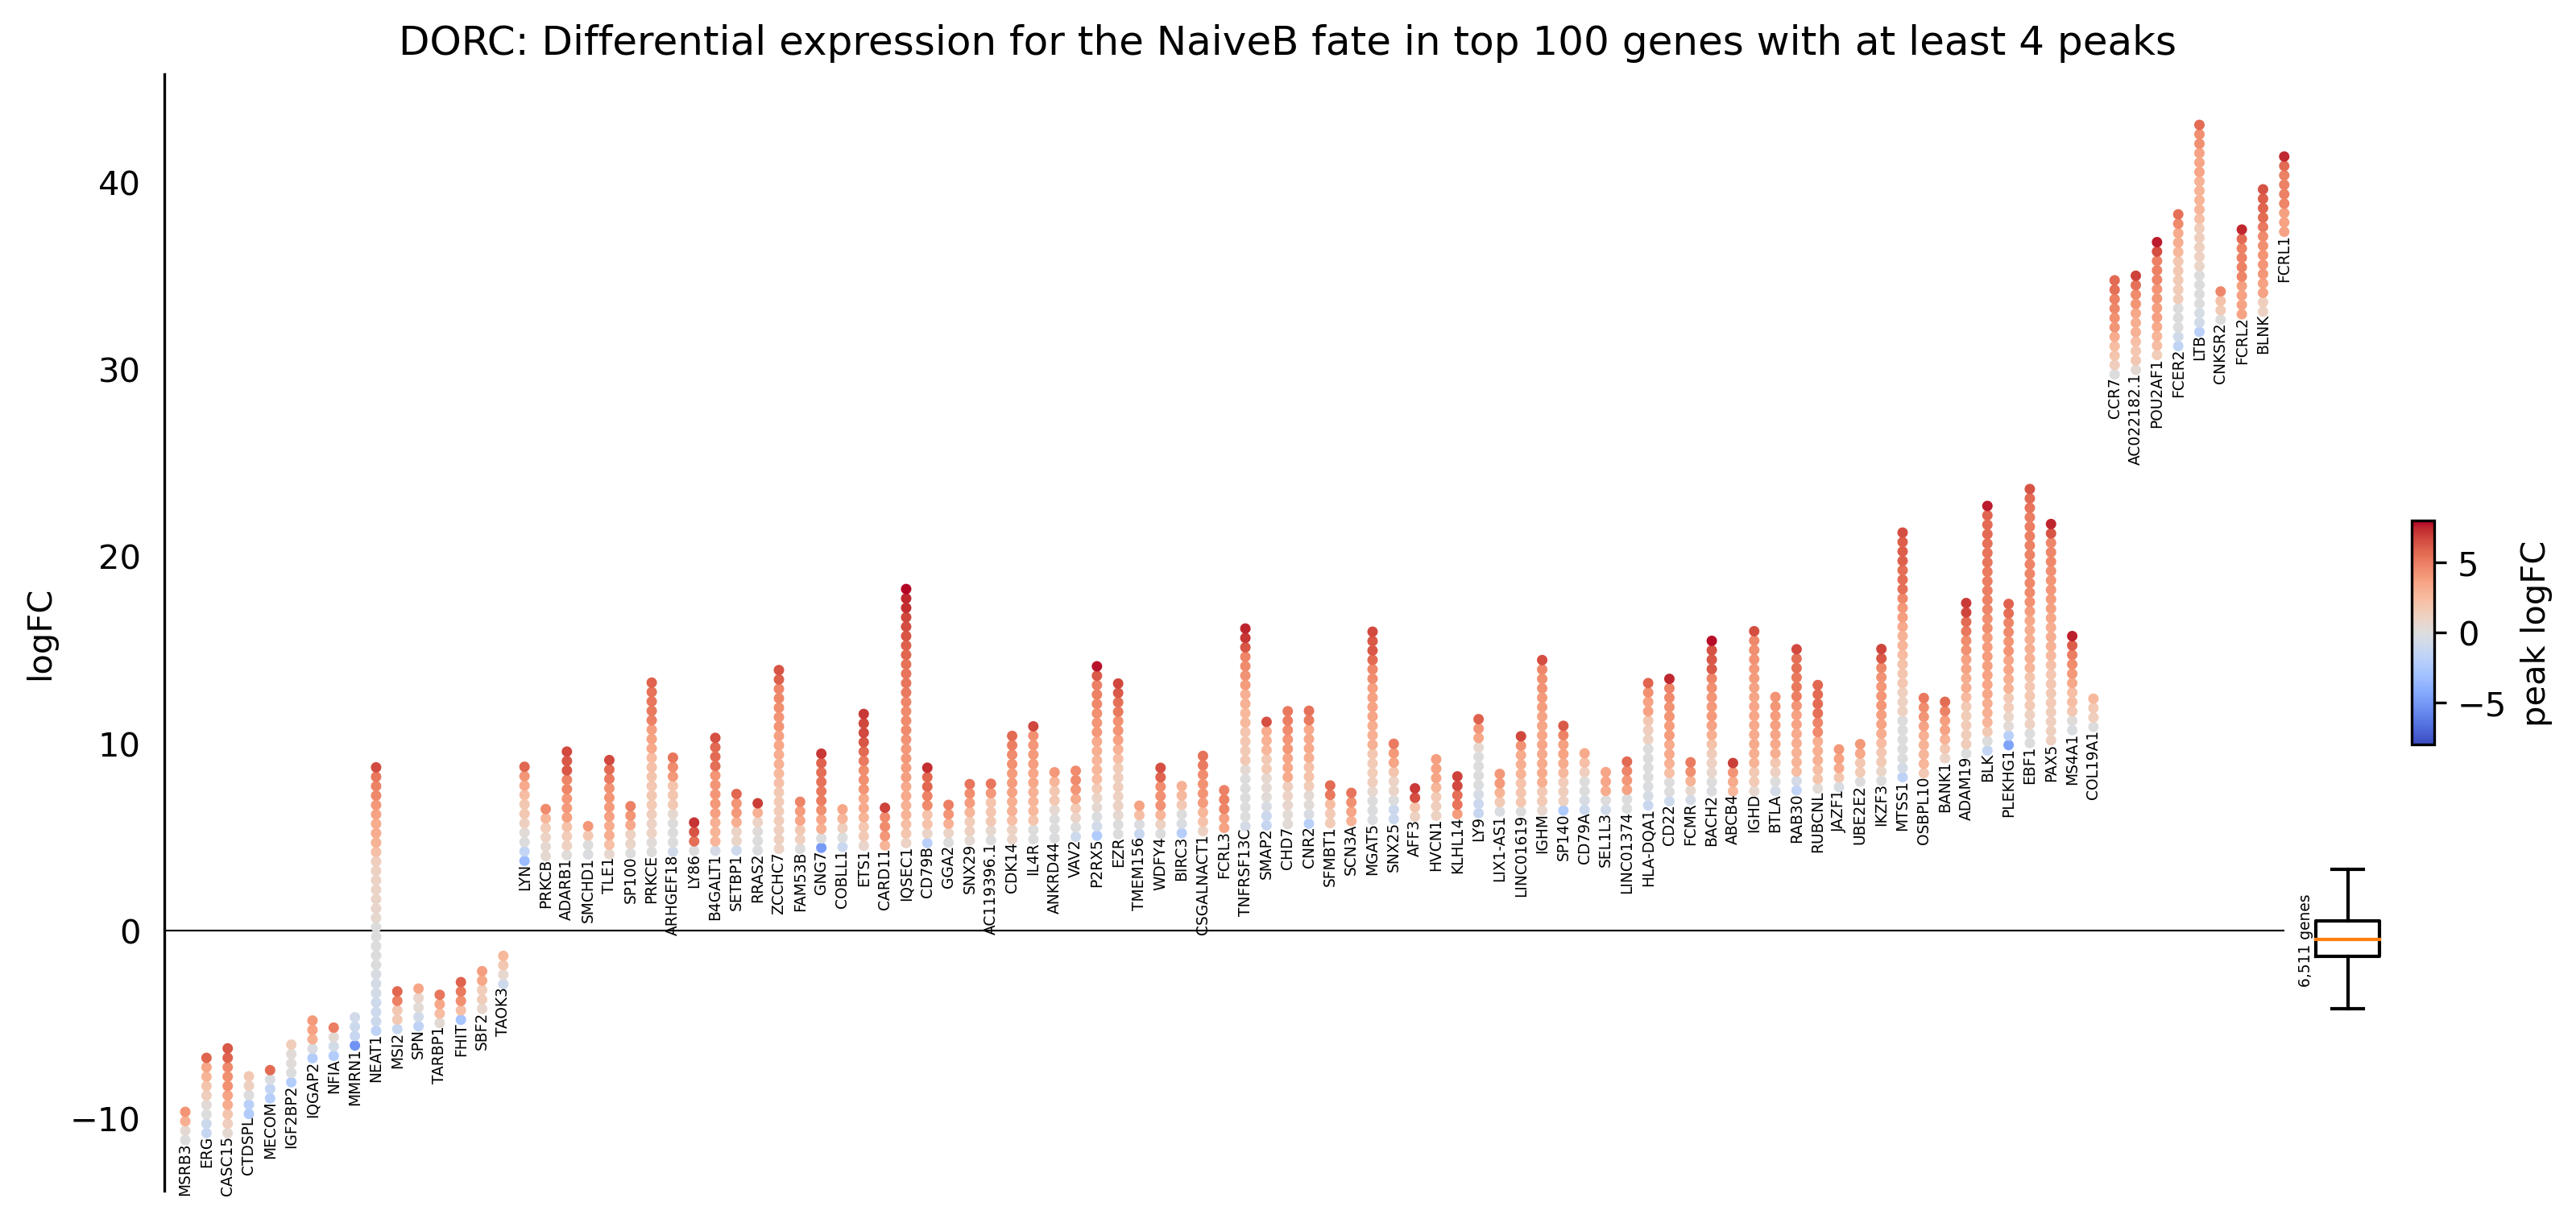

In [20]:
fig, ax, _ = enhancer_plot(
    gene_info_df, cont_colors, n_genes=n_genes, min_peaks=min_peaks
)
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create an enhancer plot with discrete colors

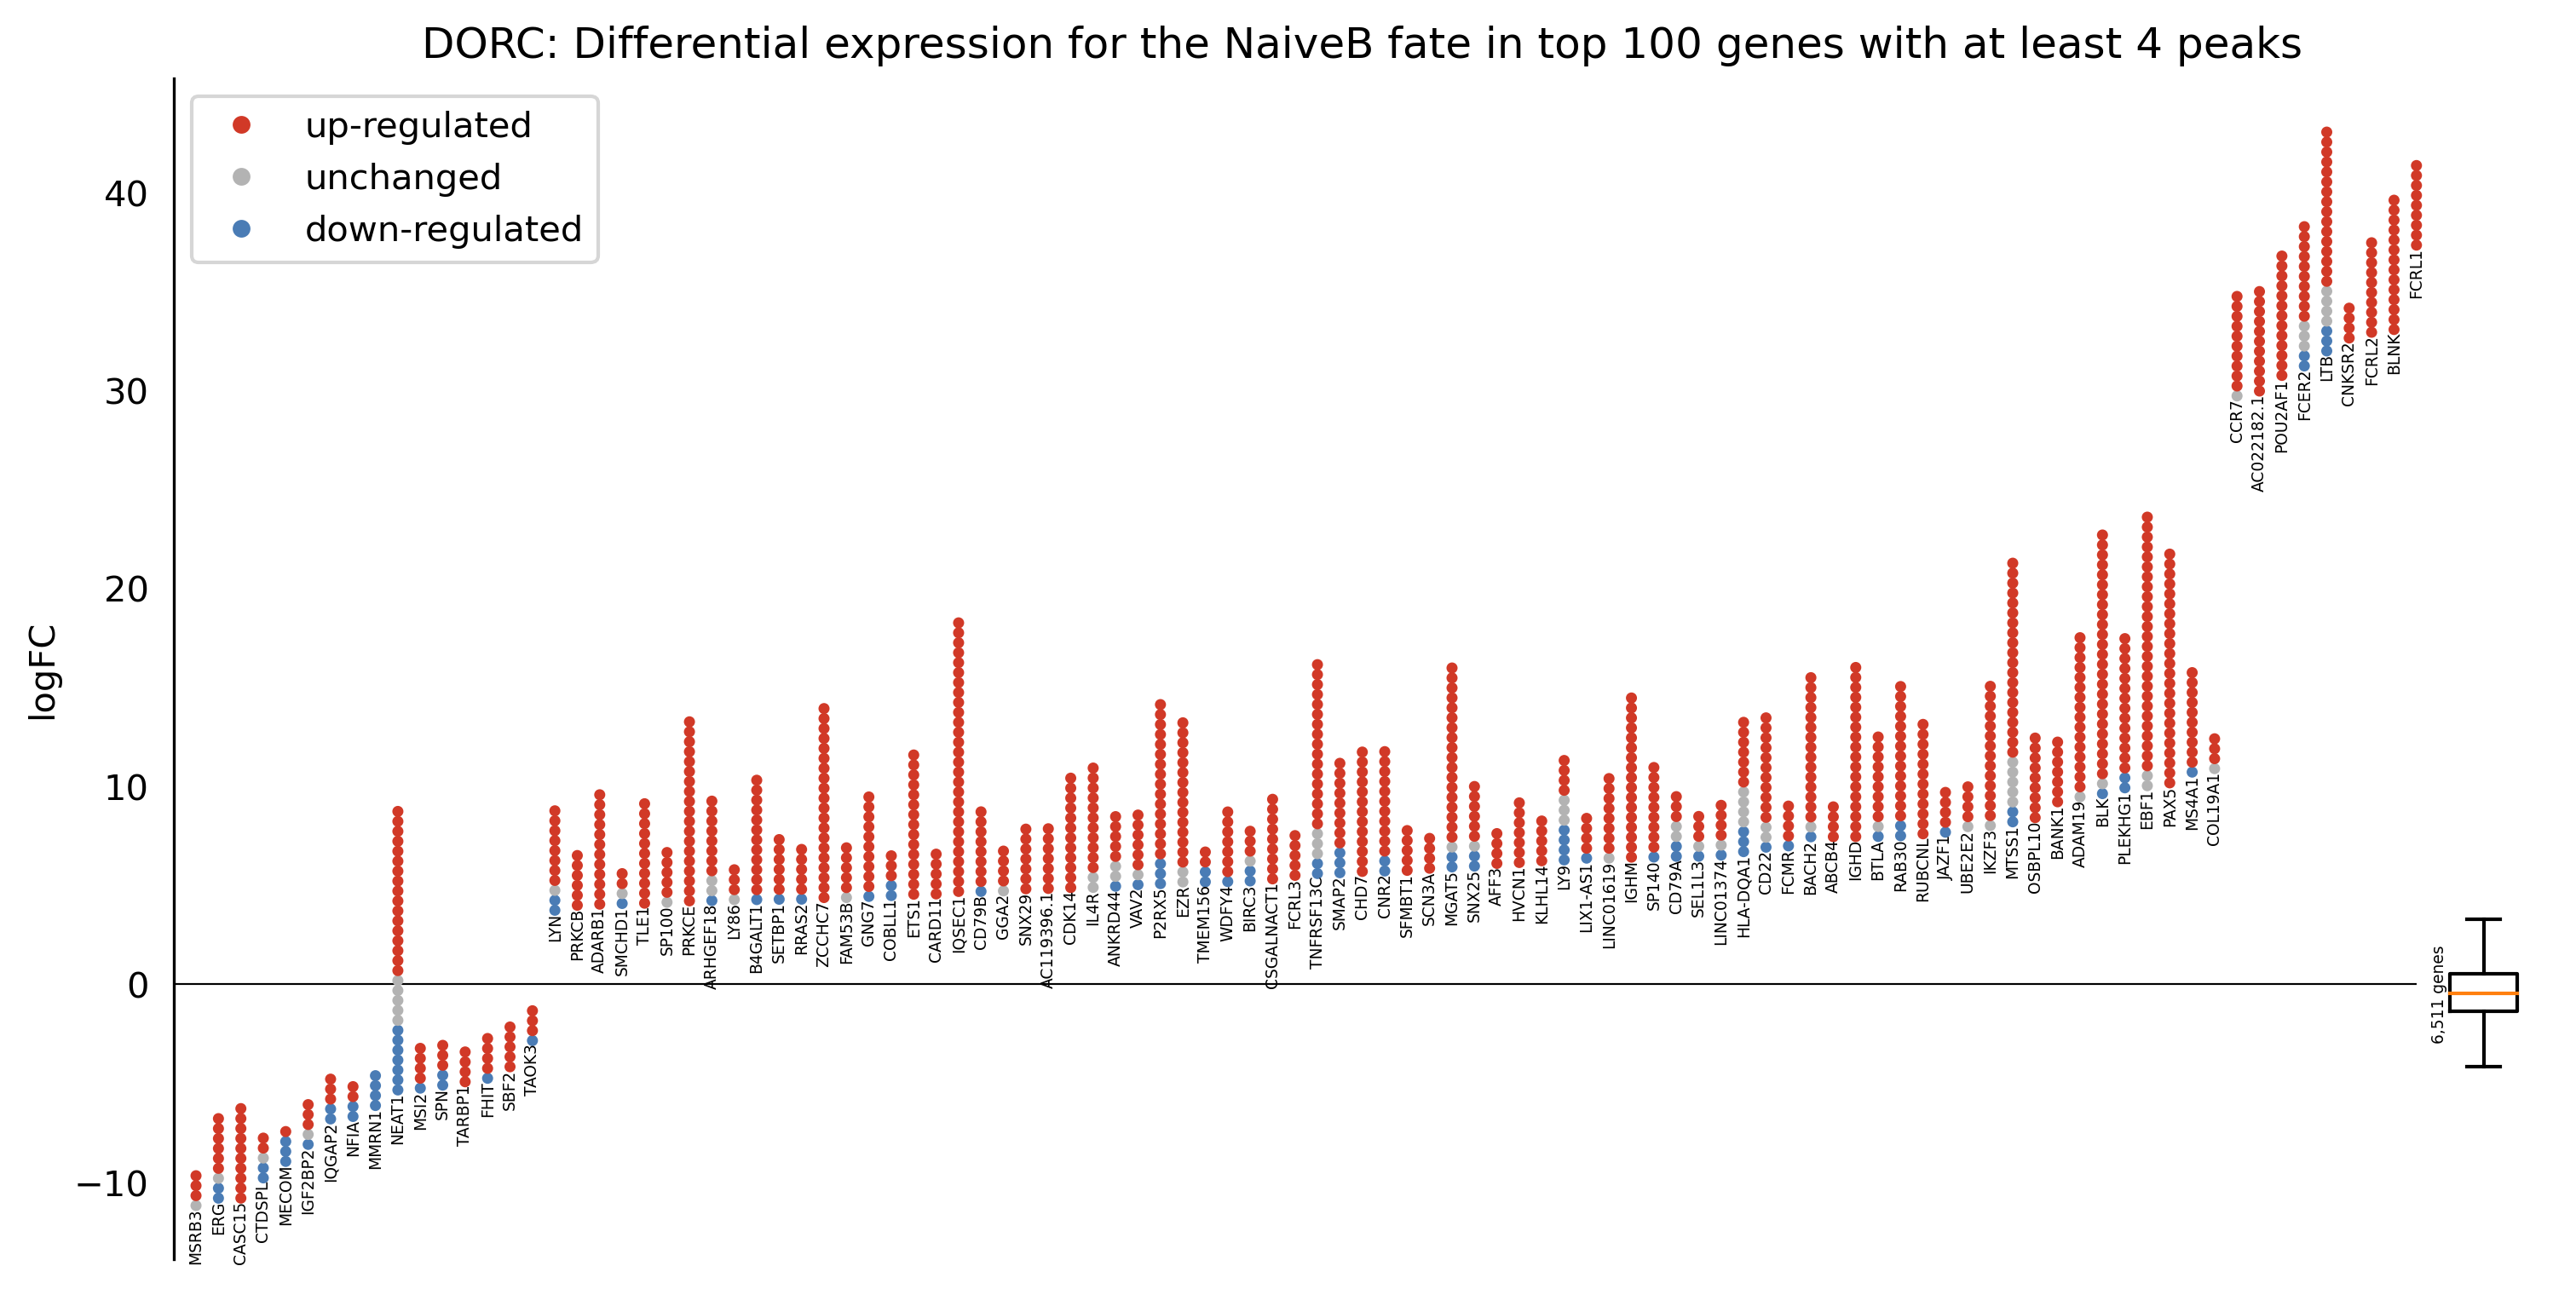

In [21]:
# Here, each gene is represented with a color based on its peak group assignment.
fig, ax, _ = enhancer_plot(
    gene_info_df, disc_colors, n_genes=n_genes, min_peaks=min_peaks, cmap=cmap
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with continuous colors

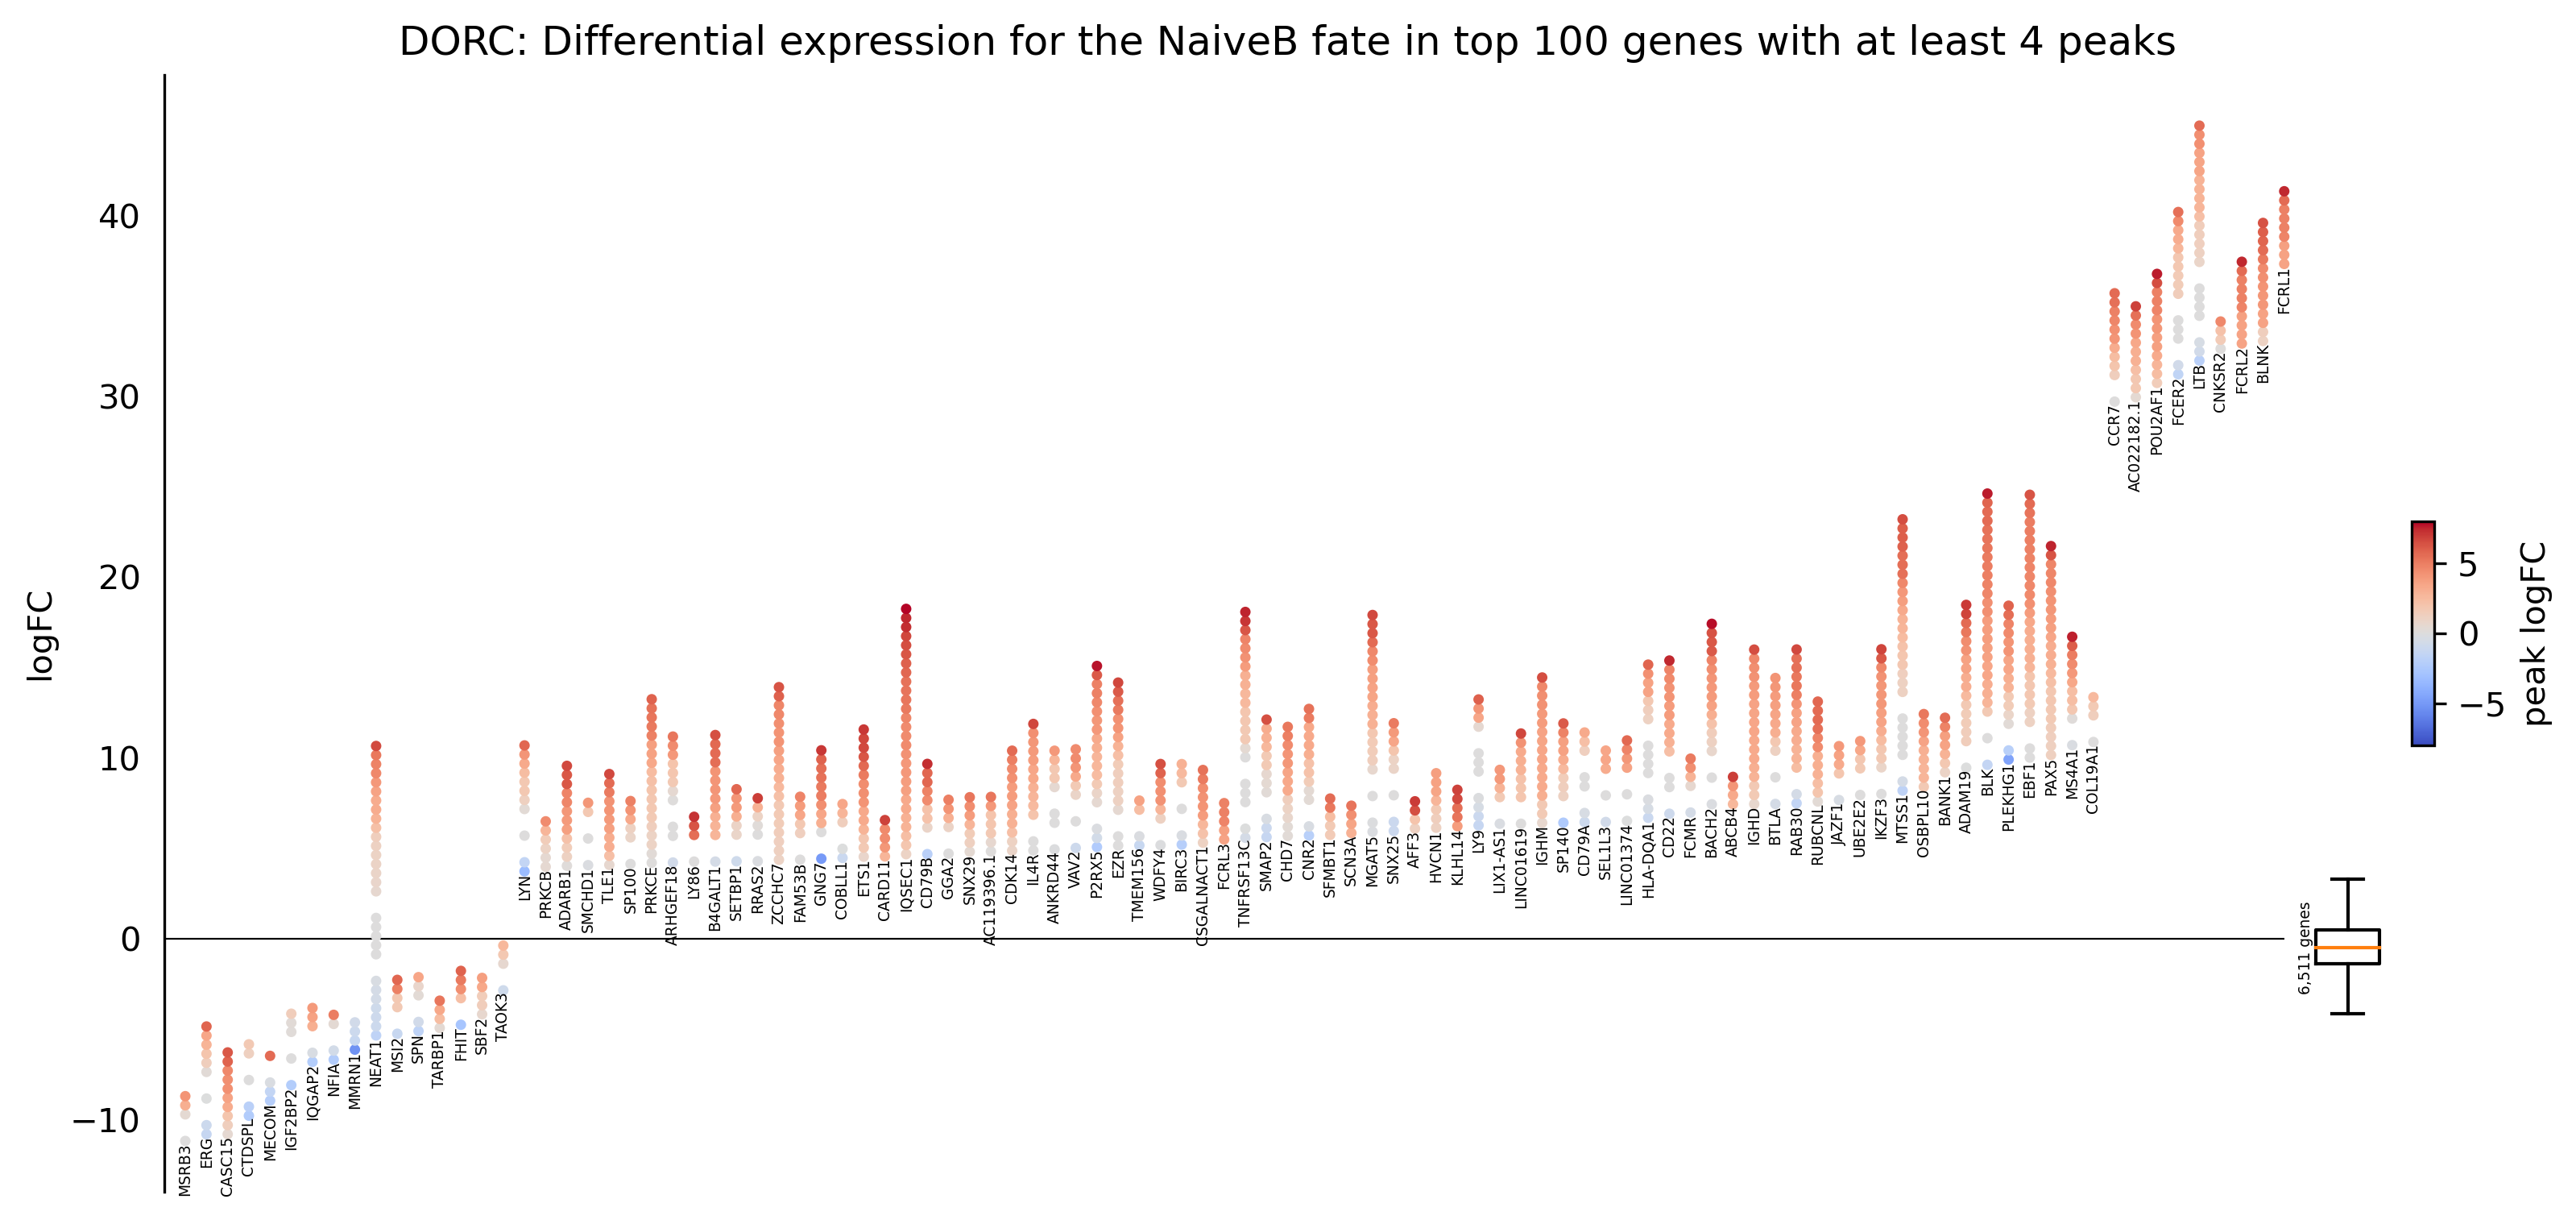

In [22]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
)
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with discrete colors

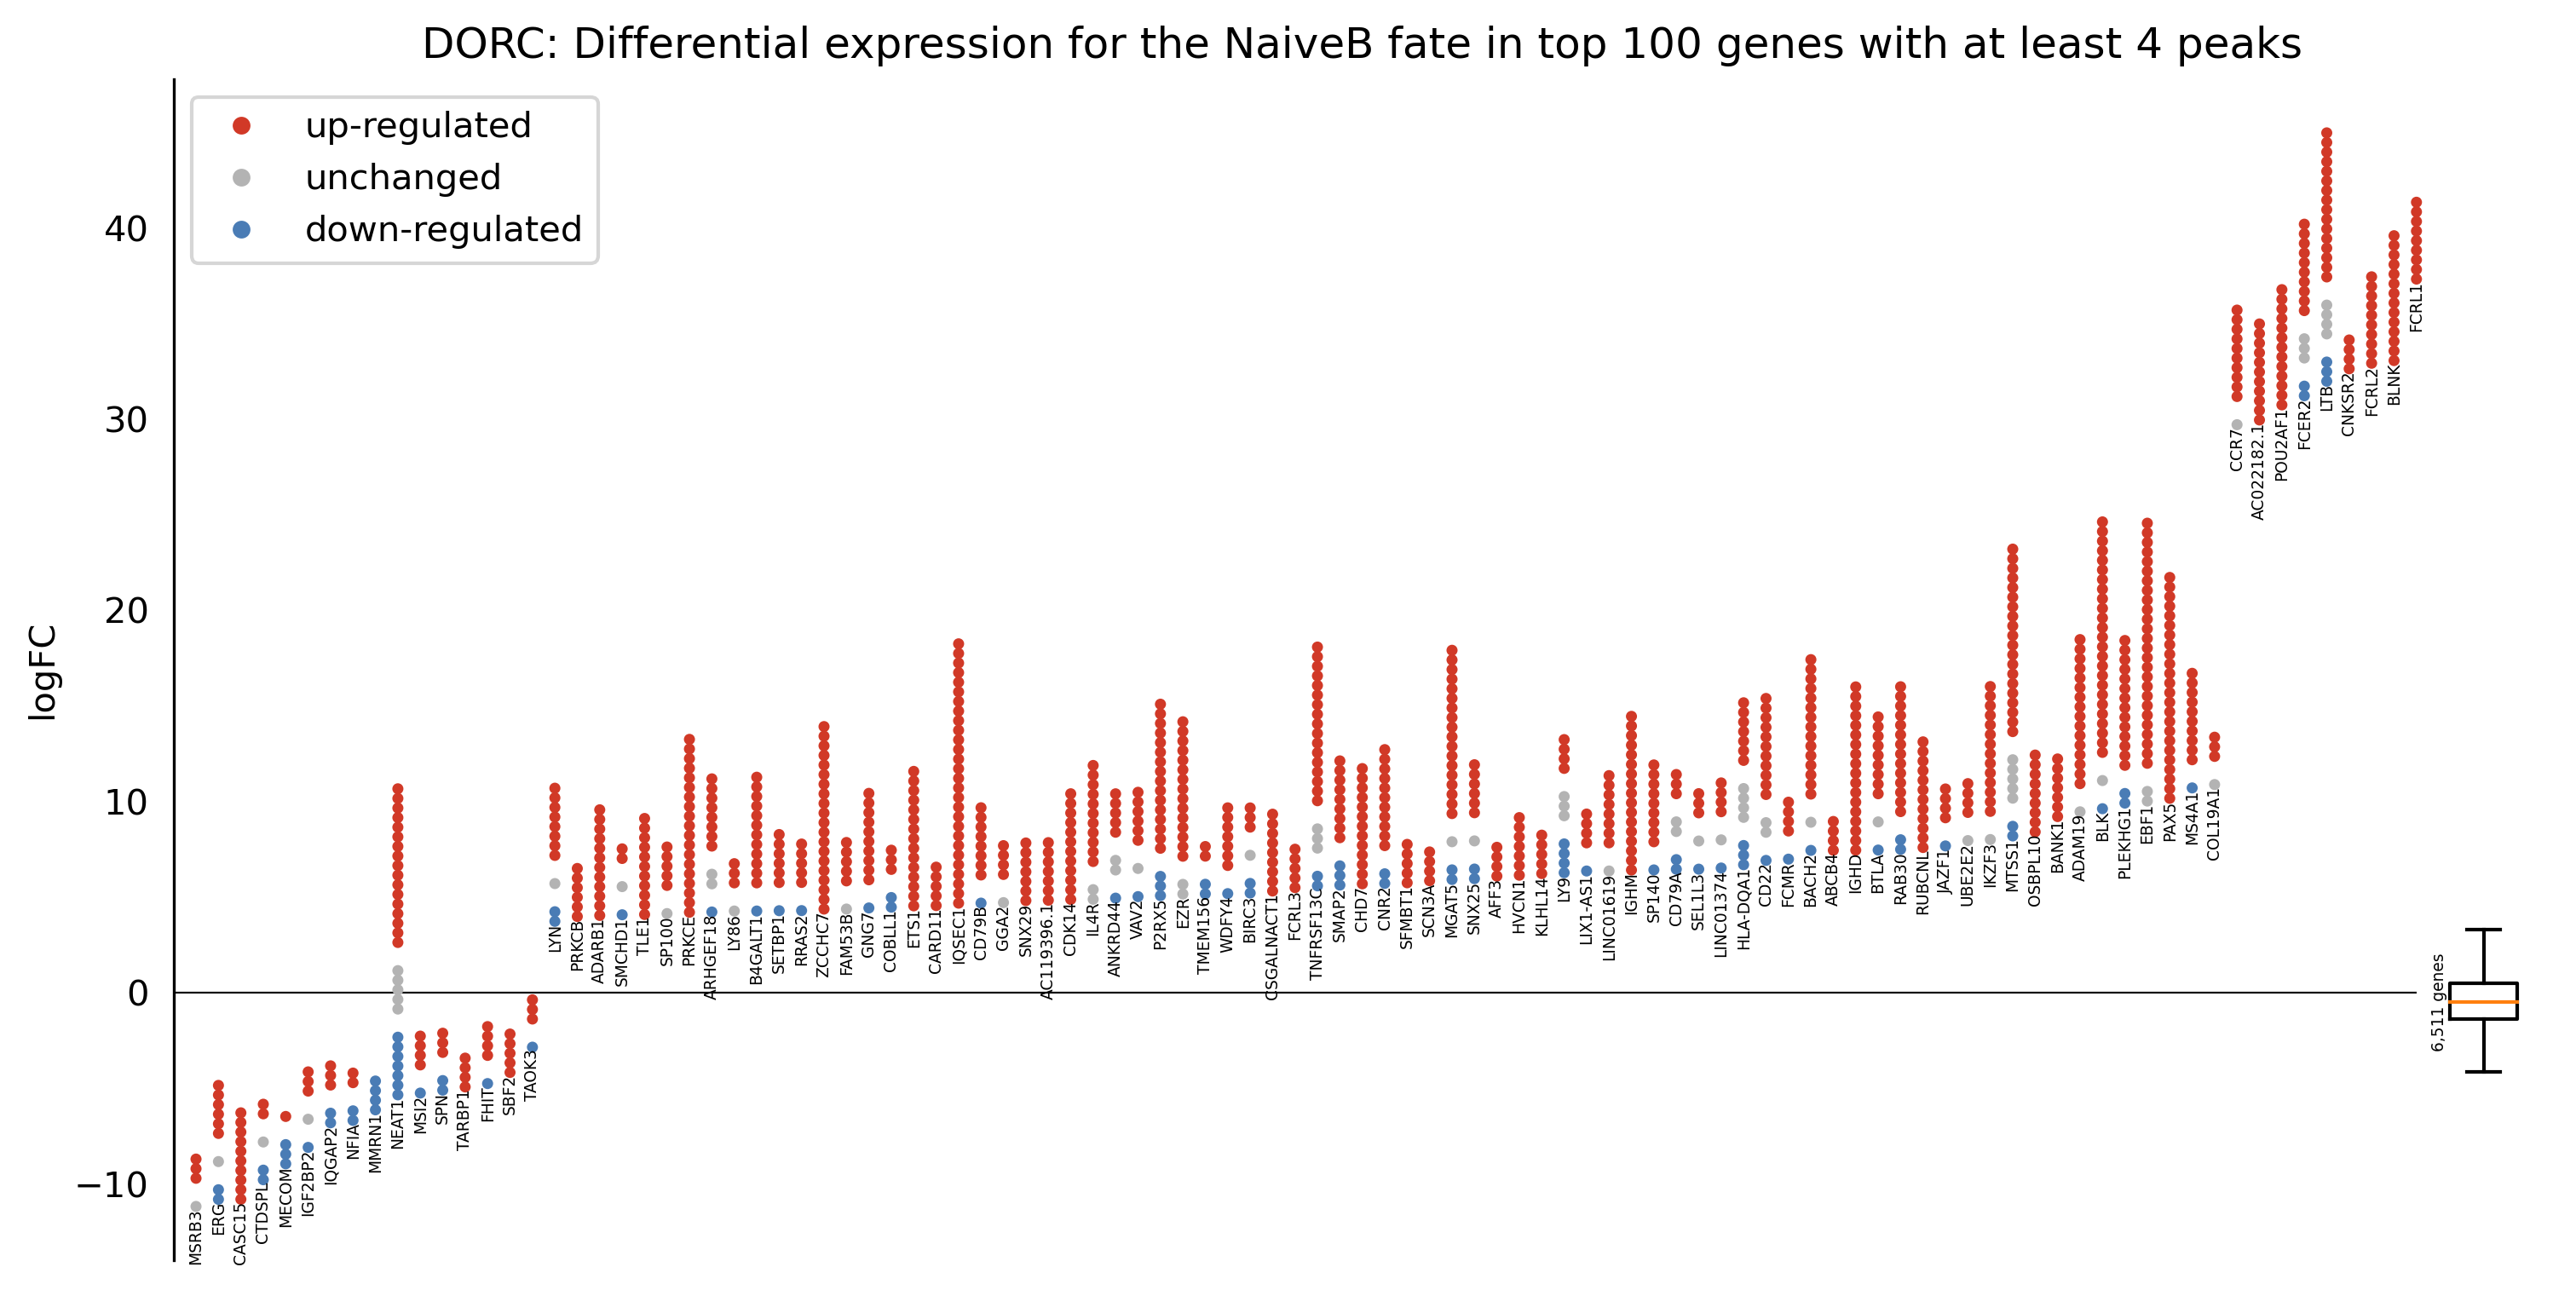

In [23]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Show a custom subset of genes

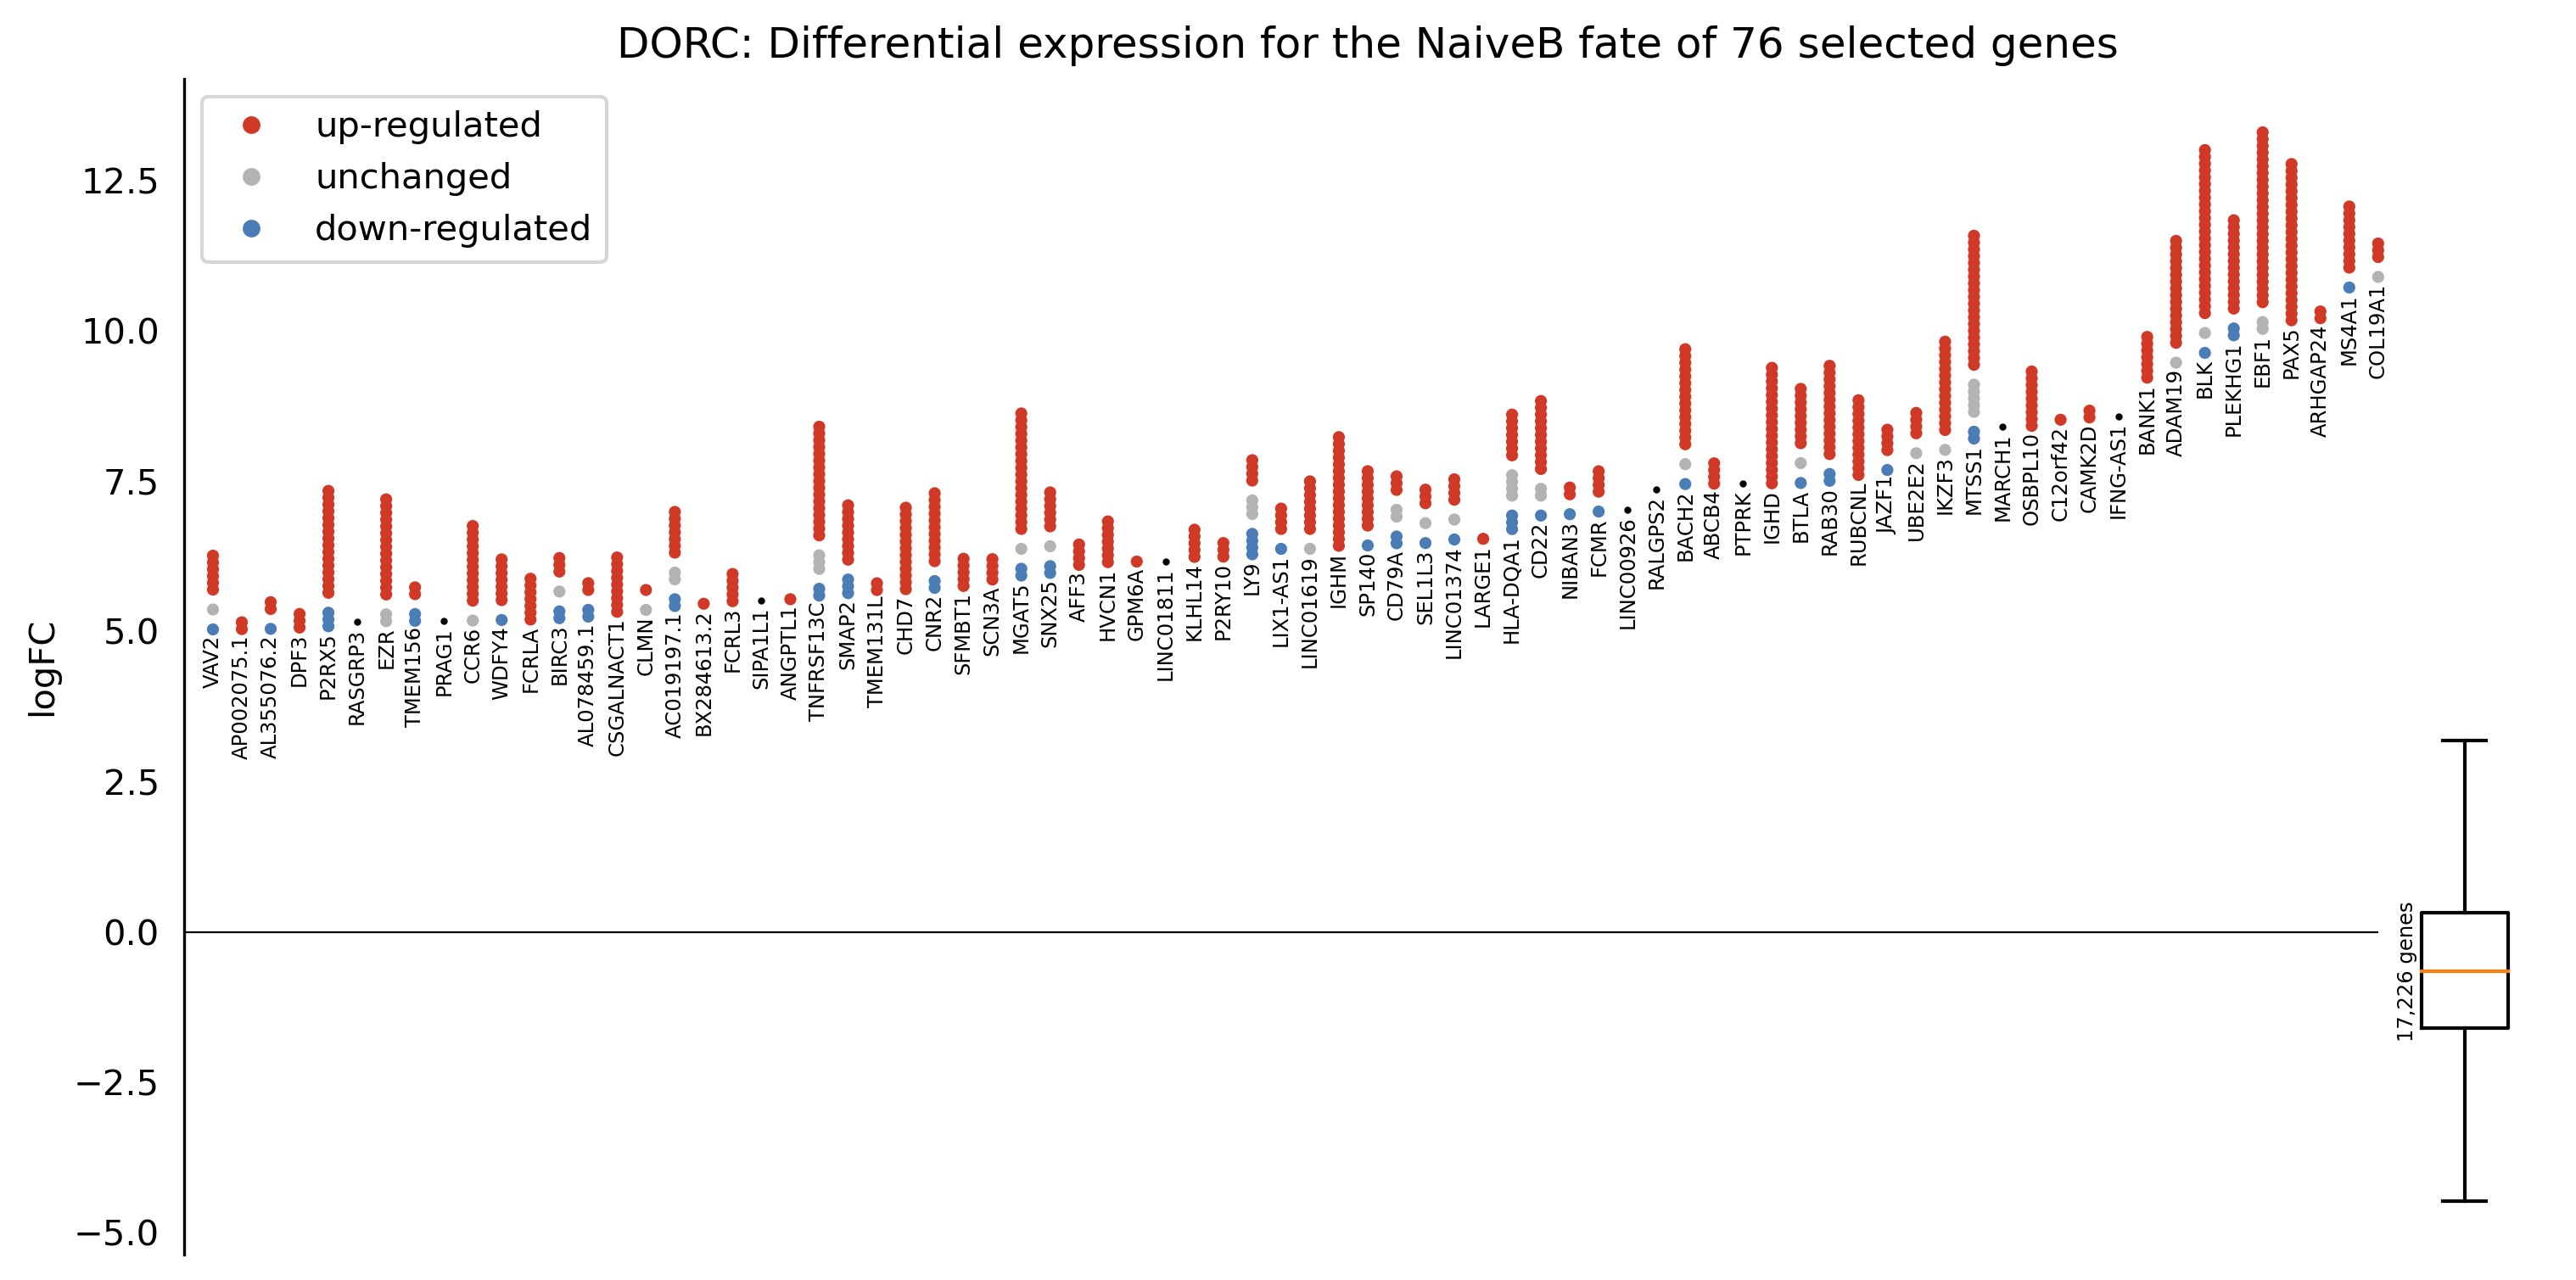

In [24]:
#Genes with no associated peaks may be shown - set min_peaks to 1 to exclude these peaks)
show_mask = (gene_info_df["logFC"]>5) & (gene_info_df["logFC"]<20) # an arbitraty condition
sorted_gene_df = pd.concat(
    [gene_info_df.loc[show_mask, :], gene_info_df.loc[~show_mask, :]]
)
n_selected_genes = int(np.sum(show_mask))
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate of {n_selected_genes} selected genes"
)
plt.show()

# Use alternative markers

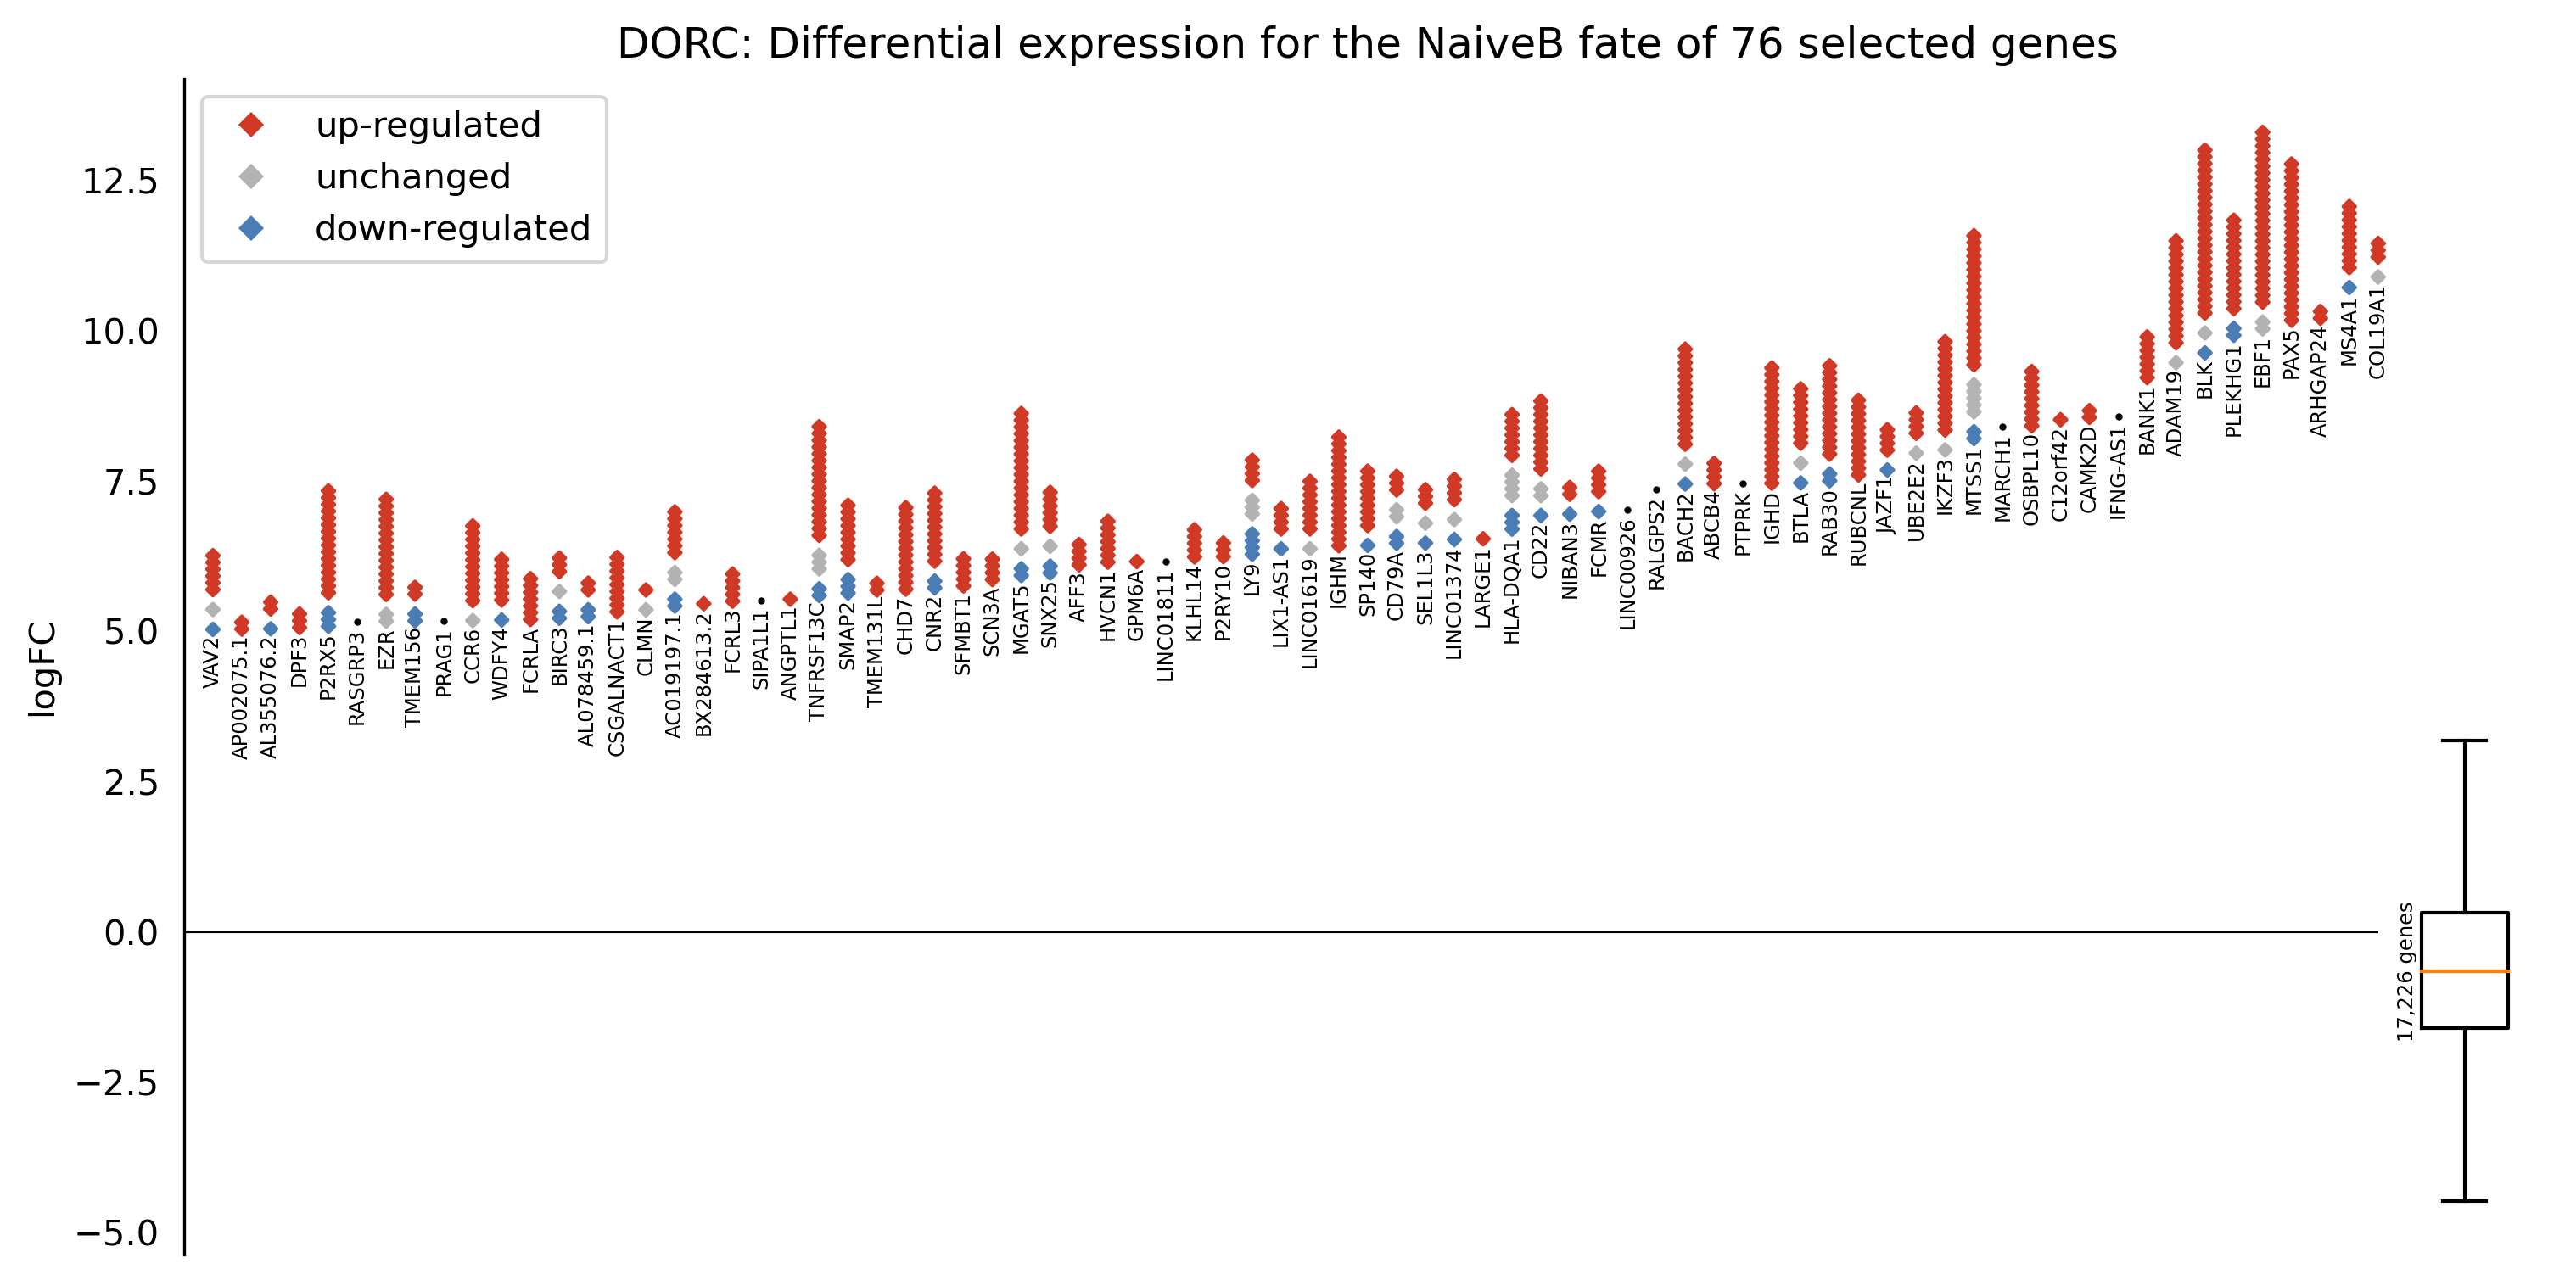

In [25]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate of {n_selected_genes} selected genes"
)
plt.show()

# More space between markers

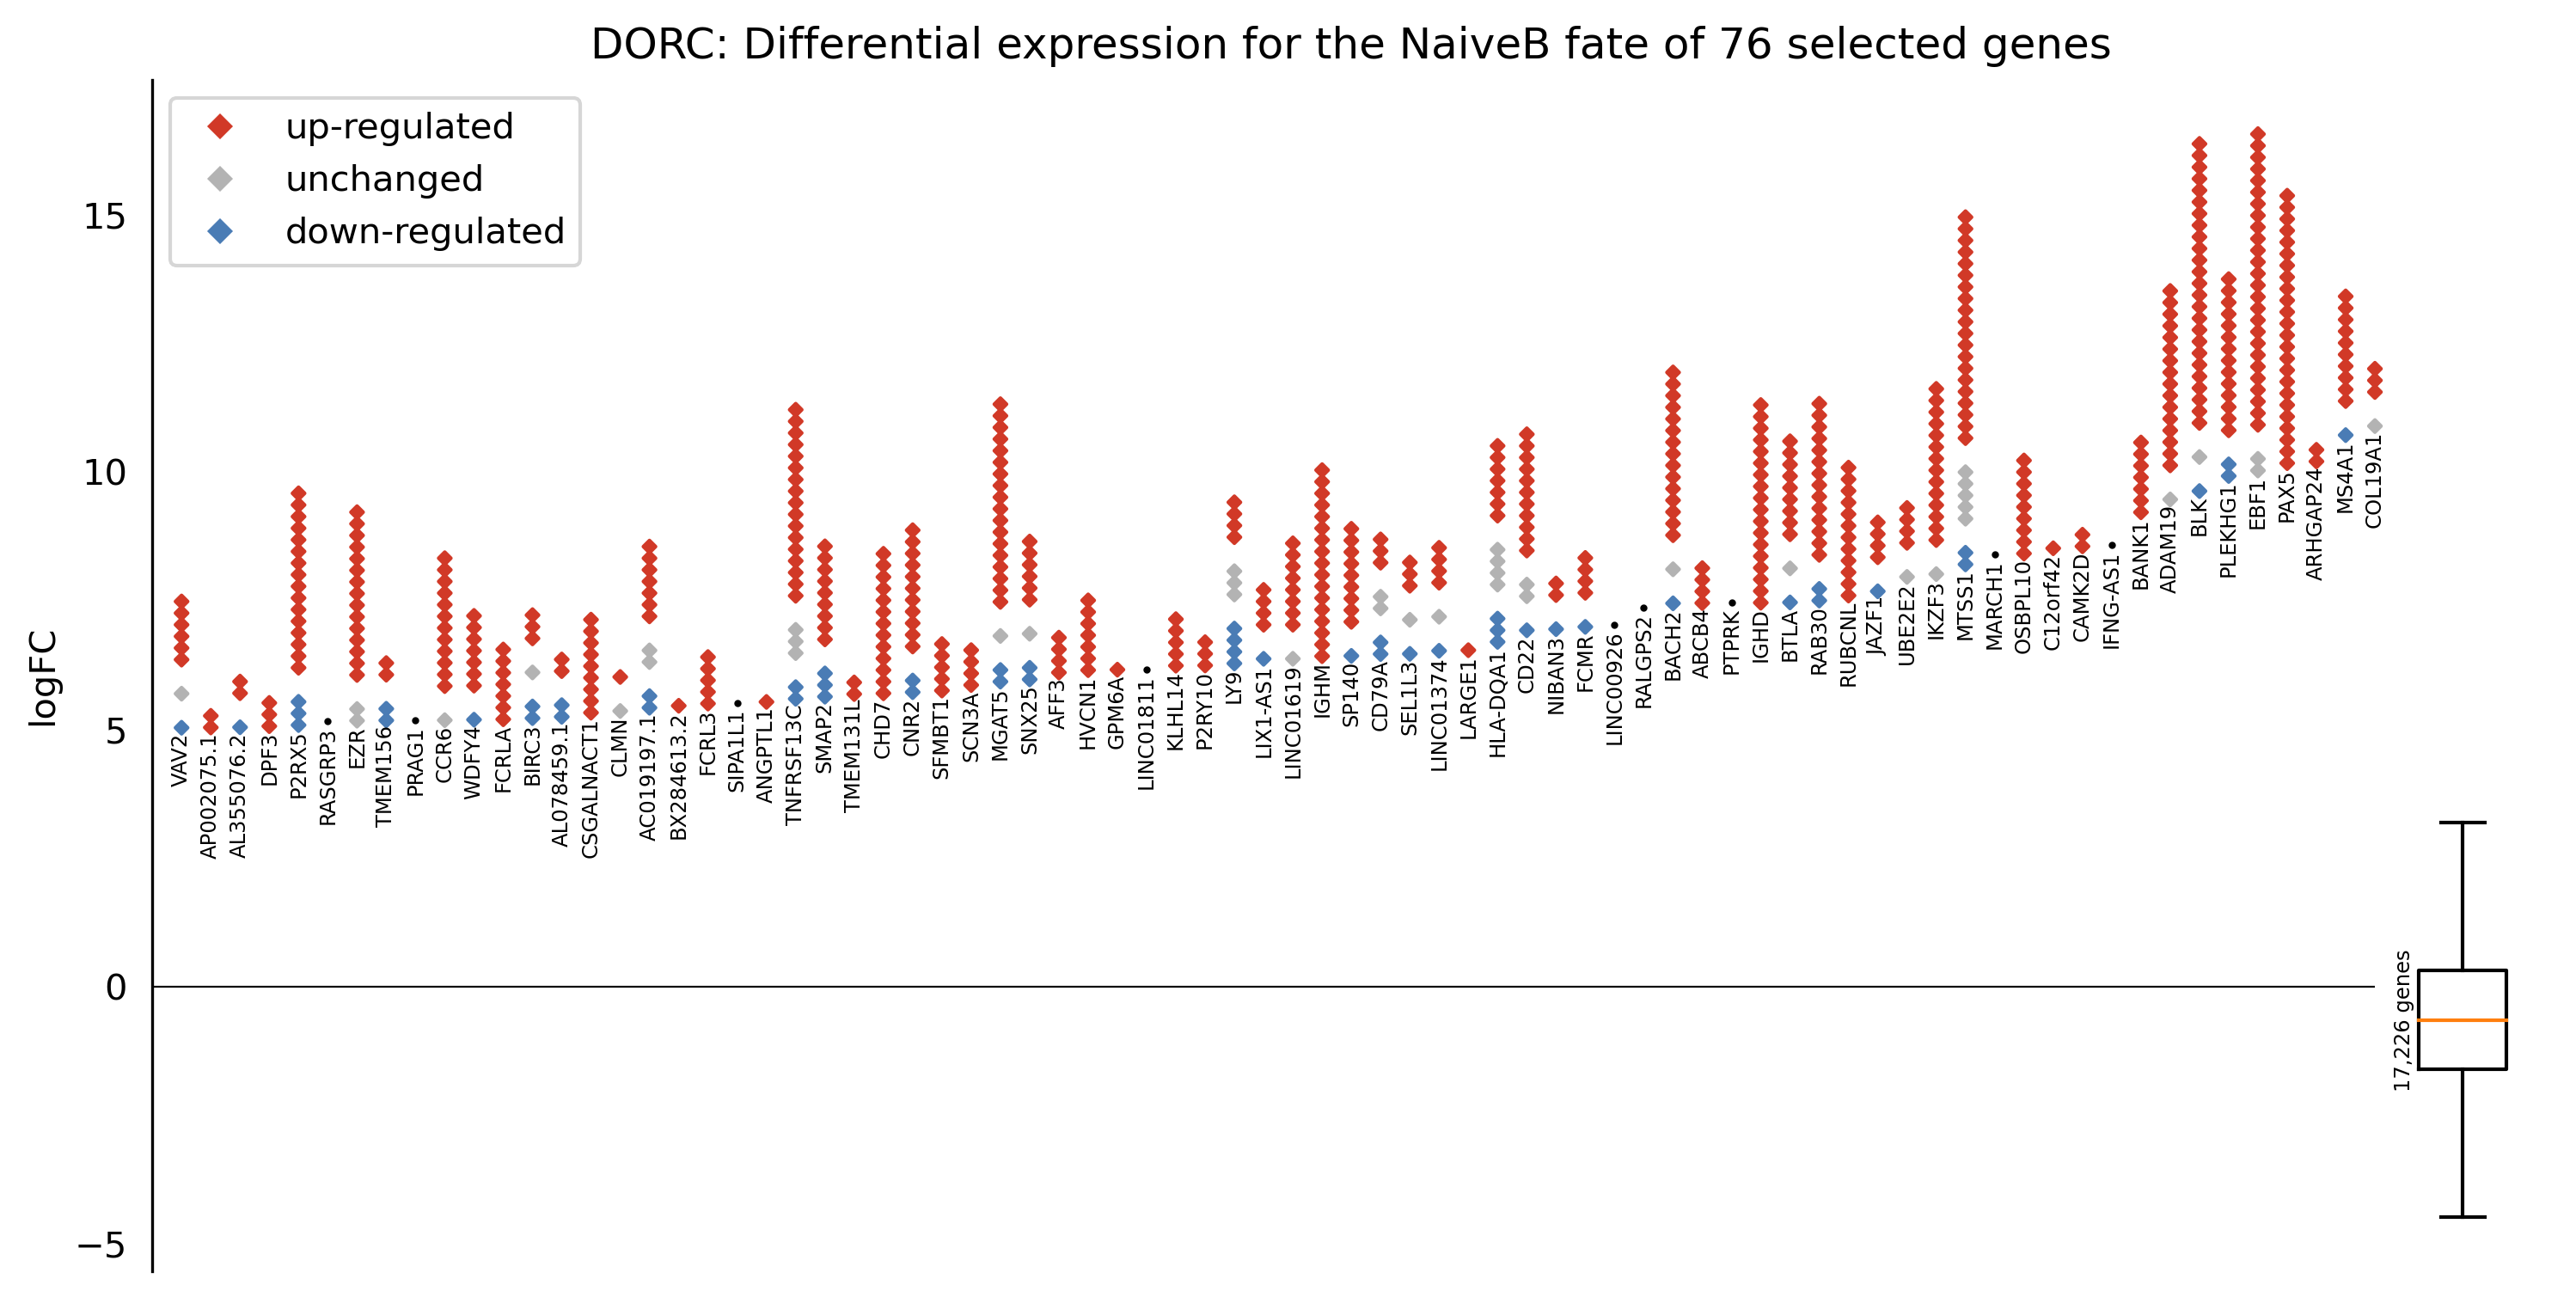

In [26]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    point_distance=2e-2,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {target_lineage} fate of {n_selected_genes} selected genes"
)
plt.show()

# Multi subplots example

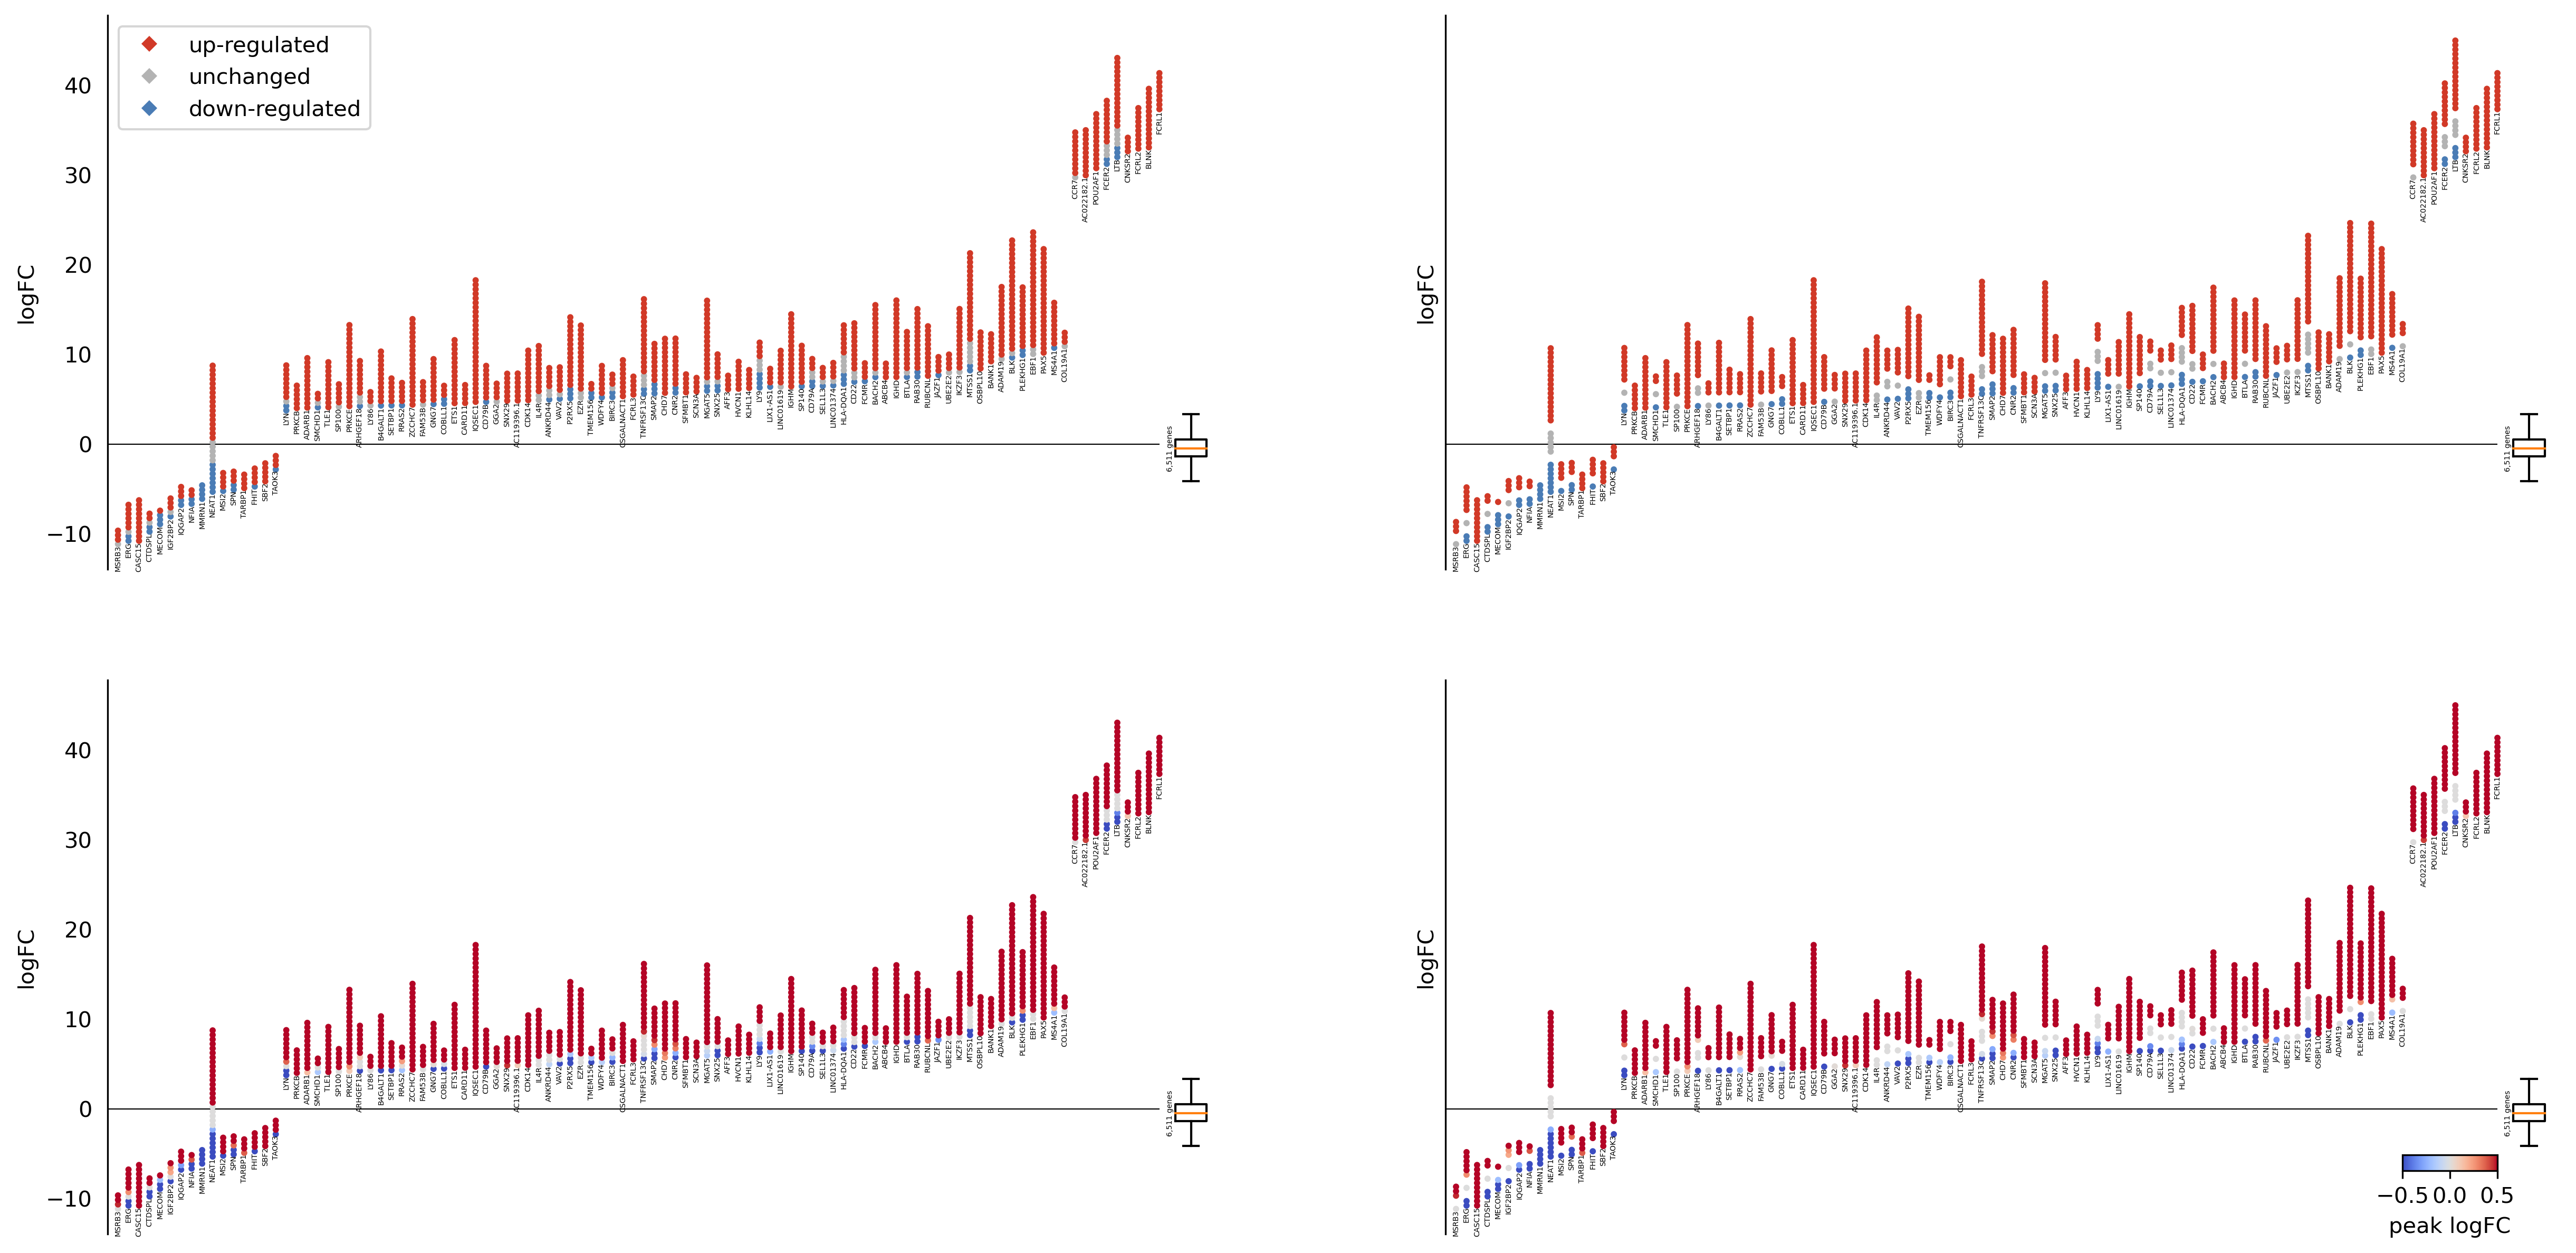

In [27]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))

# Plot using a discrete color scheme
enhancer_plot(
    gene_info_df,
    disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 0],
)
axs[0, 0].legend(handles=legend_elements, loc="upper left")

# Plot using a continuous color scheme
enhancer_plot(
    gene_info_df,
    cont_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 0],
    color_bar_bounds=None,  # Disable colorbar
    vmin=-0.5,
    vmax=0.5,  # Normalize colors to range [-0.5, 0.5]
)

# Plot using a discrete color scheme and grouping the points
enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 1],
)

# Plot using a continuous color scheme and grouping the points
fig, ax, points = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 1],
    color_bar_bounds=None,
    vmin=-0.5,
    vmax=0.5,
)

# Add a colorbar in the bottom right corner
cbar_axes = fig.add_axes([0.85, 0.15, 0.03, 0.01])
cbar = fig.colorbar(points, cax=cbar_axes, orientation="horizontal")
cbar.set_label("peak logFC")

plt.show()